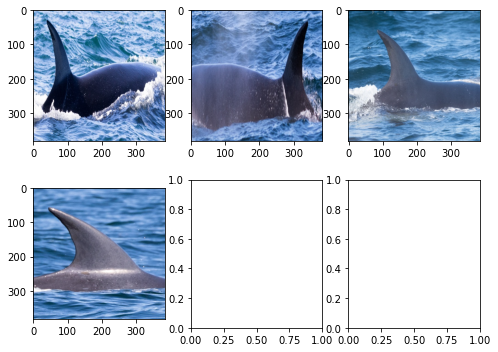

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_df = pd.read_csv('data/train_kfold.csv')
img_dir = 'D:/whale_data/train_images-384-384/train_images-384-384'
# img_dir = '/Users/macbook/works/train_images-384-384'
ids = train_df[train_df.sample_count > 1].individual_id.unique()

def random_show(train_df):
    iid = np.random.choice(ids)
    samples = train_df[train_df.individual_id == iid]
    imgs = []
    for i, row in samples.iterrows():
        img = cv2.imread(f'{img_dir}/{row.image}')[:, :, ::-1]
        if img is not None:
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(train_df)

In [13]:
train_df[train_df.sample_count == 1]

,image,species,individual_id,fold,sample_count,subset,label
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,0,1,train,12348
16,0018064338b499.jpg,blue_whale,4790ec346170,4,1,train,4345
17,001b0900f56e89.jpg,humpback_whale,bc14b5054353,3,1,train,11488
26,002618d6f63ebc.jpg,southern_right_whale,f5eab86405b4,4,1,train,14980
28,0029d877c29ab4.jpg,melon_headed_whale,c27f0a7f4e5a,1,1,train,11860
...,...,...,...,...,...,...,...
50988,ffbe97e98dc414.jpg,dusky_dolphin,dc6005ba4d2b,4,1,train,13436
51003,ffd233d91c41c7.jpg,dusky_dolphin,4de77853688d,1,1,train,4720
51005,ffda27396b72d3.jpg,melon_headed_whale,3509cb6a8504,2,1,train,3211
51012,ffe2cfd8177062.jpg,pilot_whale,e880e47c06a4,1,1,train,14182


In [ ]:
x = pd.read_csv('data/train_image.csv')
x['r'] = x.h / x.w
x = x.sort_values('h')
x

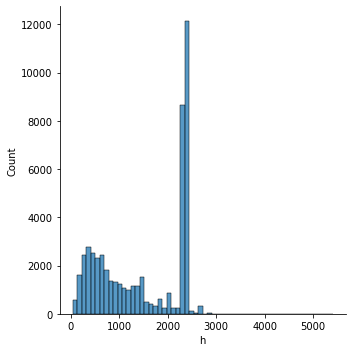

In [ ]:

_=sns.displot(x.h)

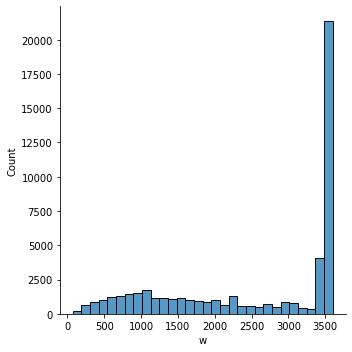

In [ ]:
_=sns.displot(x.w)

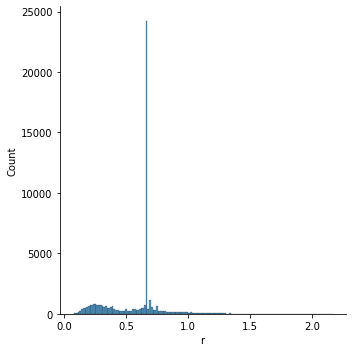

In [ ]:
_=sns.displot(x.r)

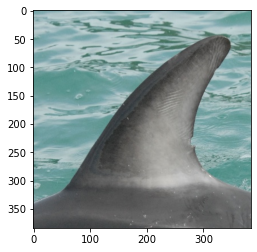

In [14]:
plt.imshow(cv2.imread(f'{img_dir}/ffbe97e98dc414.jpg')[:, :, ::-1])